- simulated data
- transformer + dataset construction
- pretrain

- analyses

In [3]:
from string import ascii_lowercase

from itertools import permutations
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import transformers
from transformers import (
    # CONFIG_MAPPING,
    # MODEL_FOR_CAUSAL_LM_MAPPING,
    # AutoConfig,
    # AutoModelForCausalLM,
    # AutoTokenizer,
    # HfArgumentParser,
    # Trainer,
    # TrainingArguments,
    # default_data_collator,
    set_seed,
)

In [4]:
import util

In [5]:
set_seed(1234)

## concepts

In [40]:
# mixture of multually exclusive and independent latent concepts
# symmatrical matrices

concept1 = np.array([   # positivity bias
    [1, 0, 1, 1],  # intention: pos
    [0, 0, 0, 0],  # intention: neg
    [1, 0, 1, 0],  # result: pos
    [1, 0, 0, 1]   # result: neg
])

concept2 = np.array([   # swing
    [1, 1, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 1],
    [0, 1, 1, 1]
])

concept3 = np.array([   # negativity bias
    [0, 0, 0, 0],
    [0, 1, 1, 1],
    [0, 1, 1, 0],
    [0, 1, 0, 1]
])

# concept4 = np.array([   # negativity bias
#     [0, 0, 0, 0],
#     [0, 1, 1, 1],
#     [0, 1, 1, 0],
#     [0, 1, 0, 1]
# ])

concepts = [concept1, concept2, concept3]

In [41]:
# training data gt (TODO: does the model capture this prob distr and use it as prior during inf?)
# do not mix concepts when generating training data?
probs_train_gt = util.normalize([1, 1, 1], ord=1)
print(probs_train_gt)

# testing data gt
probs_test_gt = util.normalize([1, 1, 1], ord=1)
# probs_test_gt = util.normalize([3, 1, 1], ord=1)
print(probs_test_gt)

[0.33333333 0.33333333 0.33333333]
[0.33333333 0.33333333 0.33333333]


In [77]:
# aggregated gt concept

concept_test_gt = np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1]
])

# concept_test_gt = np.array([
#     [1, 0, 1, 0],
#     [0, 1, 1, 0],
#     [1, 1, 1, 0],
#     [0, 0, 0, 0]
# ])

# concept_test_gt = sum(prob * concept for prob, concept in zip(probs_test_gt, concepts))
concept_test_gt

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

<Axes: >

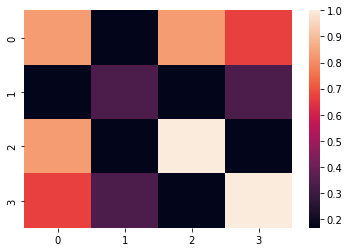

In [231]:
import seaborn as sns

sns.heatmap(concept_test_gt)

<Axes: >

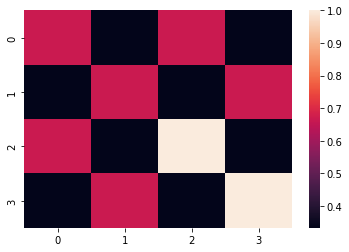

In [204]:
sns.heatmap(sum(prob * concept for prob, concept in zip(util.normalize([1, 1, 1], ord=1), concepts)))

<Axes: >

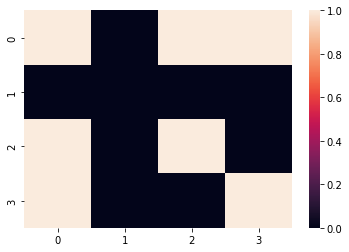

In [198]:
sns.heatmap(concept1)

<Axes: >

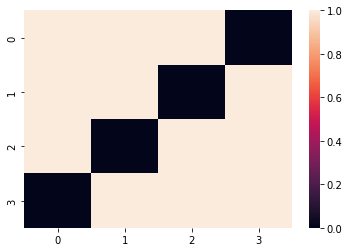

In [200]:
sns.heatmap(concept2)

<Axes: >

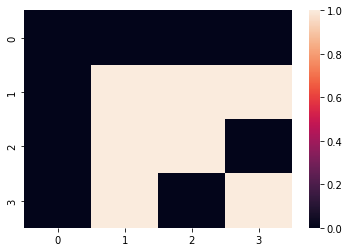

In [201]:
sns.heatmap(concept3)

## event vocab

In [48]:
n_states = concepts[0].shape[0] + 1  # n_states includes end state (always 0)
n_events = 5  # n_events includes end event ("/")

In [49]:
def gen_state2event(n_states, n_events):

    # n_states includes end state (always 0)
    # n_events includes end event ("/")

    state2event = {i:[] for i in range(n_states)}

    # state 0 (end) always instantiates as event 0 ("/")
    state2event[0] = [0]

    # other states
    for i in range(1, n_events):
        state2event[np.random.choice(range(1, n_states))].append(i)

    return state2event

In [50]:
# instantiate event from latent state
# TODO: use different token seqs to denote different states (tokens may be reused across states, but seqs not), instead of single tokens

# instantiation = gen_state2event(n_states, n_events)
instantiation = {
    0: [0],
    1: [1],
    2: [2],
    3: [3],
    4: [4]
}
instantiation

# instantiation = {
#     0: ["/"],
#     1: ["a", "b", "c", "d", "e", "f", "ab", "ac", "ad", "ae"],
#     2: ["h", "i", "j", "k", "l", "m", "n", "o", "p", "af", "ag", "ah", "ai", "aj", "ak", "al"],
#     3: ["q", "r", "s", "t", "am", "an", "ao", "ap", "aq"],
#     4: ["u", "v", "w", "x", "y", "z", "ar", "as", "at", "au", "av", "aw", "ax"]
# }

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4]}

In [124]:
import pickle
with open(f"/net/scratch/shangao/latent-concept/data/state2event_T{n_events}.pkl", "wb") as f:
    pickle.dump(instantiation, f)

In [51]:
# https://github.com/p-lambda/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/generate_data.py#L128
def letter_generator(num):
    counter = 0
    for i in range(1, len(ascii_lowercase)):
        for perm in permutations(ascii_lowercase, i):
            yield ''.join(perm)
            counter += 1
            if counter >= num:
                return
            

# generate vocab
vocab = list(letter_generator(n_events-1))  # excluding end event
# replace delimiters with more interpretable tokens
vocab = ['/'] + vocab   # end event is indexed as event 0
vocab

['/', 'a', 'b', 'c', 'd']

In [52]:
# https://github.com/p-lambda/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/generate_data.py#L138
def apply_vocab(tokens, vocab):
    return [vocab[tok] for tok in tokens]

## tokenizer

In [53]:
def save_tokenizer_json(vocab, filename):
    vocab = list(vocab)
    vocab = vocab + ['[endoftext]']  # put [endoftext] last to ensure emb idx matches event idx
    vocab_dict = {v: i for i, v in enumerate(vocab)}
    tokenizer_config = {"version":"1.0","truncation": None,"padding": None,"added_tokens":[{"id":0,"special":True,"content":"[endoftext]","single_word":False,"lstrip":False,"rstrip":False,"normalized":False}],"normalizer":None,"pre_tokenizer":{"type":"Whitespace"},"post_processor":None,"decoder":None,"model":{"type":"WordLevel","vocab":vocab_dict,"unk_token":"<unk>"}}
    with open(filename, 'w') as f:
        json.dump(tokenizer_config, f)

save_tokenizer_json(vocab, f'/net/scratch/shangao/latent-concept/data/tokenizer_{n_events}.json')

## generate obs

In [54]:
# generate: concept (transition matrix) >> latent state seq >> instantiate event
def gen_obs(concept, end_prob=0.5, sample_length=None):

    state_seq = []
    event_seq = []

    init_state_probs = concept.diagonal()
    state_present = init_state_probs > 0
    num_states = sum(state_present)

    # append a col of end state to the left of concept mtx, with each prob 1/num_states
    end_prob_each = (end_prob * state_present / num_states).reshape(-1, 1)  # convert to shape nx1
    concept = np.hstack((end_prob_each, concept))  # append to the left of concept mtx

    while True:

        # randomly select a state accroding to their probs to start chaining
        # print(util.normalize(init_state_probs), sum(util.normalize(init_state_probs)))
        state_chosen = np.random.choice(len(init_state_probs), p=util.normalize(init_state_probs)) + 1  # states are 1-indexed; 0 denotes end state
        state_seq.append(state_chosen)
        # instantiate event from state
        event_seq.append(np.random.choice(instantiation[state_chosen]))

        # generate next states/events
        while state_chosen != 0:
            if sample_length and len(state_seq) >= sample_length: 
                return state_seq, event_seq
            state_probs = concept[state_chosen-1]
            state_probs[state_chosen] = 0  # diag of concept mtx denotes presence of states instead of self-self transition prob
            state_chosen = np.random.choice(len(state_probs), p=util.normalize(state_probs))
            # print(util.normalize(state_probs), sum(util.normalize(state_probs)))
            # print('state_chosen', state_chosen, state_probs)
            state_seq.append(state_chosen)
            event_seq.append(np.random.choice(instantiation[state_chosen]))
        
        if (sample_length is None) or (sample_length and len(state_seq) >= sample_length): 
            return state_seq, event_seq


    # return state_seq, event_seq

In [55]:
# sanity
concept_test_gt_thres = concept_test_gt.copy()
# concept_test_gt_thres[concept_test_gt_thres < 0.5] = 0
gen_obs(concept_test_gt_thres, end_prob=0.3, sample_length=20)

([3, 1, 4, 2, 4, 3, 1, 4, 1, 3, 2, 1, 4, 2, 4, 1, 2, 0, 3, 2],
 [3, 1, 4, 2, 4, 3, 1, 4, 1, 3, 2, 1, 4, 2, 4, 1, 2, 0, 3, 2])

### mixture of concepts

In [56]:
# sample from the list of concepts with probs_train_gt to gen_obs
# https://github.com/p-lambda/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/generate_data.py#L319

def gen_samples(num_samples, id_concepts, end_prob, random_data, sample_length=1024):

    samples = []

    for i in tqdm(range(num_samples)):

        # randomly select concept to generate obs
        j = np.random.choice(len(id_concepts))
        # print('j', j)
        if not random_data:
            h, x = gen_obs(id_concepts[j], end_prob=end_prob, sample_length=sample_length)
        
        # if generating random_data
        else:
            h = np.random.randint(low=0, high=n_states, size=sample_length)
            x = np.random.randint(low=0, high=len(vocab), size=sample_length)
        x = apply_vocab(x, vocab)
        samples.append({'text': ' '.join(x), 'concept_idx': j, 'concept_type': 'id', 'hiddens': h})

    return samples

In [153]:
# sec = 'train'
# num_samples=1000
sec = 'val'
num_samples=500
end_prob=0.3
random_data=False
# random_data=True
sample_length=1024

samples = gen_samples(num_samples, concepts, end_prob, random_data, sample_length)
len(samples[0]['hiddens'])

100%|██████████| 500/500 [00:18<00:00, 27.18it/s]


1024

### aggregated concept

In [57]:
def gen_aggregated_samples(num_samples, agg_concepts, end_prob, random_data, sample_length=None):

    samples = []

    for i in tqdm(range(num_samples)):

        if not random_data:
            h, x = gen_obs(agg_concepts, end_prob=end_prob, sample_length=sample_length)
        
        # if generating random_data
        else:
            h = np.random.randint(low=0, high=n_states, size=sample_length)
            x = np.random.randint(low=0, high=len(vocab), size=sample_length)

        x = apply_vocab(x, vocab)
        samples.append({'text': ' '.join(x), 'concept_probs_gt': probs_test_gt, 'concept_type': 'agg', 'hiddens': h})

    return samples

In [58]:
def gen_aggregated_prompts(num_samples, agg_concepts, end_prob, random_data, sample_length=20):

    samples = []

    for i in tqdm(range(num_samples)):

        # print('iter', i)

        if not random_data:

            h, x = gen_obs(agg_concepts, end_prob=end_prob, sample_length=sample_length)

            # generate next state label
            last_state_chosen = h[-1]
            agg_concepts_copy = agg_concepts.copy()  # otherwise agg_concepts will be mutated
            init_state_probs = agg_concepts_copy.diagonal()

            if last_state_chosen != 0:

                # state_probs = agg_concepts_copy[last_state_chosen-1]
                # state_probs[last_state_chosen-1] = 0  # diag of concept mtx denotes presence of states instead of self-self transition prob
                # test_value_h = np.argmax(util.normalize(state_probs)) + 1  # only state matters, not event

                state_present = init_state_probs > 0
                num_states = sum(state_present)
                # append a col of end state to the left of concept mtx, with each prob 1/num_states
                end_prob_each = (end_prob * state_present / num_states).reshape(-1, 1)  # convert to shape nx1
                agg_concepts_copy = np.hstack((end_prob_each, agg_concepts_copy))  # append to the left of concept mtx
        
                state_probs = agg_concepts_copy[last_state_chosen-1]
                state_probs[last_state_chosen] = 0  # diag of concept mtx denotes presence of states instead of self-self transition prob
                test_value_h = np.argmax(util.normalize(state_probs)) # only state matters, not event

                if test_value_h == 0:
                    i -= 1
                    continue
            
            else:
                test_value_h = np.random.choice(len(init_state_probs), p=util.normalize(init_state_probs)) + 1  # states are 1-indexed; 0 denotes end state

                
            
        # if generating random_data
        else:
            h = np.random.randint(low=0, high=n_states, size=sample_length)
            x = np.random.randint(low=0, high=len(vocab), size=sample_length)
            test_value_h = np.random.randint(low=0, high=5)
            if test_value_h == 0:
                    i -= 1
                    continue

        x = apply_vocab(x, vocab)

        samples.append({'text': ' '.join(x), 'labels': test_value_h, 'x': x, 'concept_probs_gt': probs_test_gt, 'concept_type': 'agg', 'hiddens': h})

    return samples

In [90]:
# sec = 'agg_train_prompts'
# num_samples=1000
# sec = f'agg{probs_test_gt}_val_prompts'  # TODO: add probs_test_gt will break load_dataset()
# sec = 'agg111_val_prompts_noend'
sec = 'rdn_val_prompts_noend'
# sec = 'unseen1s_val_prompts_noend'
num_samples=500
end_prob=0.3
# random_data=False
random_data=True
sample_length=50

# samples = gen_aggregated_samples(num_samples, concept_test_gt, end_prob, random_data, sample_length)
# len(samples[0]['hiddens'])

if not random_data:
    print(concept_test_gt)
else: 
    print('random')

samples = gen_aggregated_prompts(num_samples, concept_test_gt, end_prob, random_data, sample_length)

random


100%|██████████| 500/500 [00:00<00:00, 46796.80it/s]


### save

In [91]:
def save_as_json(samples, save_path):
    df = pd.DataFrame(samples)
    df.to_json(save_path, orient='records', lines=True)

def samples_to_raw(samples, out_path):
    with open(out_path, 'w') as f:
        for sample in samples:
            f.write(sample['text'] + ' / ')

save_as_json(samples, f'/net/scratch/shangao/latent-concept/data/{sec}_T{n_events}_N{num_samples}_L{sample_length}_E{end_prob}.json')
samples_to_raw(samples, f'/net/scratch/shangao/latent-concept/data/{sec}_T{n_events}_N{num_samples}_L{sample_length}_E{end_prob}.txt')

## bayesian inf

In [31]:
states_obs = [2,1,4,3,1,3,1,4,1,4,1,3,1,3,2,4,2,3,1,3,1,3,1,3,1,3,2,1,3,1,3,1,4,3,2,4,1,2,4,1,4,2,1,4,1,3,1,3,1,4]

In [32]:
def compute_posterior(obs, domain, p_concepts):

    n_states = domain[0].shape[0]
    n_concepts = len(domain)
    posteriors = [p_concepts]
    density = np.zeros((n_states, n_states))

    ## TODO: first state ##
    density[obs[0]-1, obs[0]-1] += 1

    likelihoods = np.full(n_concepts, np.nan)
    for j in range(n_concepts):
        concept = concepts[j]
        corr = np.corrcoef(density.flatten(), concept.flatten())[0, 1]
        likelihood = (corr - (-1)) / 2
        likelihoods[j] = likelihood
        # print(corr, likelihood)

    # update posterior
    p_concepts = util.normalize(likelihoods * p_concepts)
    posteriors.append(p_concepts)
    #####################

    for i in range(len(obs)-1):
    # for i in range(10-1):

        prev = obs[i] - 1
        next = obs[i+1] - 1
        density[prev, next] += 1
        density[next, prev] += 1

        likelihoods = np.full(n_concepts, np.nan)
        for j in range(n_concepts):
            concept = concepts[j]
            corr = np.corrcoef(density.flatten(), concept.flatten())[0, 1]
            likelihood = (corr - (-1)) / 2
            likelihoods[j] = likelihood
            # print(corr, likelihood)
        
        # update posterior
        p_concepts = util.normalize(likelihoods * p_concepts)
        posteriors.append(p_concepts)

    return posteriors

In [33]:
def compute_convergence(distrib_pred, distrib_gt):

    # if all values are equal, add perturbation to prevent error in corr calculation
    if np.all(distrib_pred == distrib_pred[0]):
        perturbation = np.random.normal(loc=0, scale=1e-6, size=distrib_pred.shape)
        distrib_pred = distrib_pred + perturbation
    if np.all(distrib_gt == distrib_gt[0]):
        perturbation = np.random.normal(loc=0, scale=1e-6, size=distrib_gt.shape)
        distrib_gt = distrib_gt + perturbation
    
    corr = np.corrcoef(distrib_pred, distrib_gt)[0, 1]

    # convert from [-1, 1] to [0, 1]
    return (corr - (-1)) / 2

In [34]:
posteriors = compute_posterior(obs=states_obs, domain=concepts, p_concepts=probs_train_gt)
print(len(posteriors))

accuracys = [compute_convergence(posterior, probs_test_gt) for posterior in posteriors]
accuracys

51


[0.9417600144224302,
 0.018193222625176364,
 0.021618970220707356,
 0.061552790695439785,
 0.21545065895609167,
 0.34273903351857377,
 0.3763776510094439,
 0.39764427678262854,
 0.48574200223798514,
 0.7069271537043212,
 0.9333197812006648,
 0.991367806255225,
 0.9985455626654536,
 0.9996929564675027,
 0.9999232267034758,
 0.9999848544058079,
 0.9999966569535879,
 0.9999991435620827,
 0.9999998310707872,
 0.9999999596246938,
 0.9999999888039501,
 0.9999999965106923,
 0.9999999988060706,
 0.9999999995592334,
 0.9999999998267435,
 0.9999999999282208,
 0.9999999999689064,
 0.999999999987515,
 0.9999999999946607,
 0.9999999999976215,
 0.9999999999989024,
 0.9999999999994778,
 0.9999999999997448,
 0.9999999999998885,
 0.9999999999999489,
 0.999999999999978,
 0.99999999999999,
 0.9999999999999958,
 0.9999999999999983,
 0.9999999999999993,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [35]:
import pickle
with open(f"/net/scratch/shangao/latent-concept/outputs_simulation/agg311_bayesian_L{len(states_obs)}.pkl", "wb") as f:
    pickle.dump(
        {'posteriors': posteriors, 'accuracys': accuracys}
        , 
        f
    )

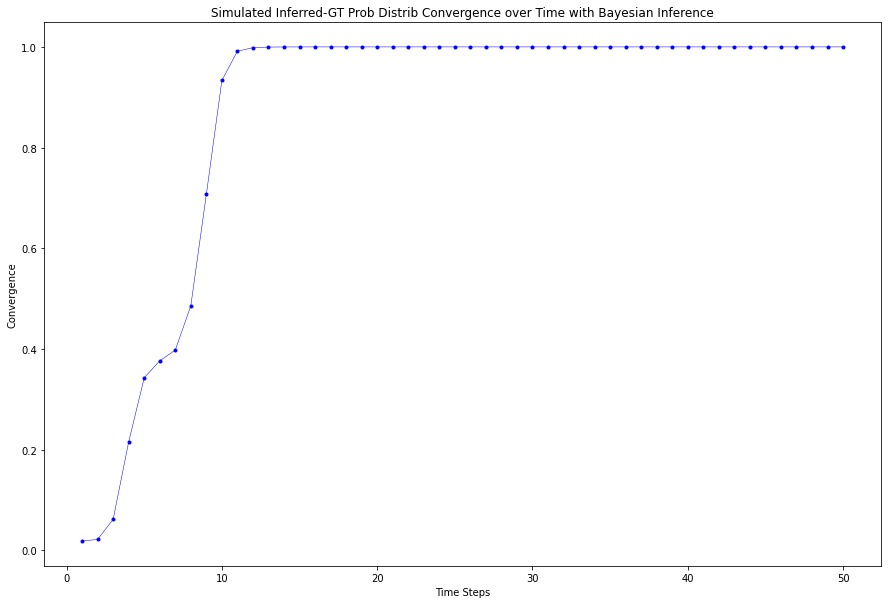

In [98]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(np.arange(1, len(accuracys)), accuracys[1:], marker='.', linestyle='-', color='b', label=f'simulated convergence', linewidth=.5)


ax.set_title('Simulated Inferred-GT Prob Distrib Convergence over Time with Bayesian Inference')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Convergence')
# ax.legend()

# fig.supxlabel('Sparsity')
# plt.tight_layout()
plt.show()